In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

import seaborn as sns

import scipy
from scipy.optimize import minimize
from scipy.stats import beta, cauchy, gamma
from plotly import express as px

# Show graphics in plotly locally
import plotly.io as pio
pio.renderers.default = 'iframe'

import pymc3 as pm
import arviz as az


import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [18]:
pm.__version__

'3.11.5'

# Stationary state of Markov chain

In [19]:
state_space = ("sunny", "cloudy", "rainy")

In [20]:
transition_matrix = np.array(((0.6, 0.3, 0.1),
                              (0.3, 0.4, 0.3),
                              (0.2, 0.3, 0.5)))

In [5]:
n_steps = 20000
states = [0]
for i in range(n_steps):
    states.append(np.random.choice((0, 1, 2), p=transition_matrix[states[-1]]))
states = np.array(states)

In [21]:
def despine(ax, spines=('top', 'left', 'right')):
    for spine in spines:
        ax.spines[spine].set_visible(False)

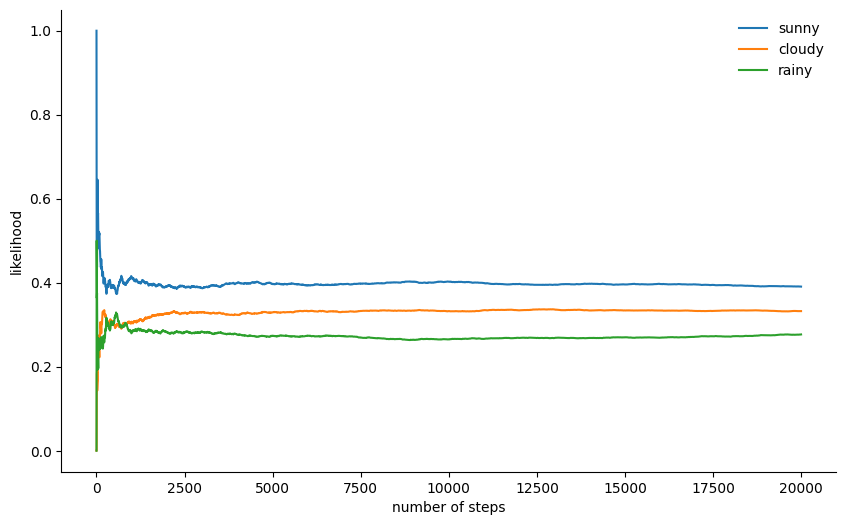

In [22]:
fig, ax = plt.subplots()
width = 1000
offsets = range(1, n_steps, 5)
for i, label in enumerate(state_space):
    ax.plot(offsets, [np.sum(states[:offset] == i) / offset 
            for offset in offsets], label=label)
ax.set_xlabel("number of steps")
ax.set_ylabel("likelihood")
ax.legend(frameon=False)
despine(ax, ('top', 'right'))
# plt.savefig('Stac.jpg')

In [23]:
# Стационарное состояние MC

# Составляем систему уравнений
A = np.transpose(transition_matrix) - np.eye(3)
A[2, :] = [1, 1, 1]  # Учитываем уравнение суммы вероятностей
b = np.array([0, 0, 1])

# Решаем систему уравнений
pi = np.linalg.solve(A, b)

print("Стационарное состояние (вероятности):", np.round(pi, 4))

Стационарное состояние (вероятности): [0.3889 0.3333 0.2778]


# Rejection sampling

In [24]:
def p_params(a=1, b=1):
    distr = beta(a, b)
    return distr

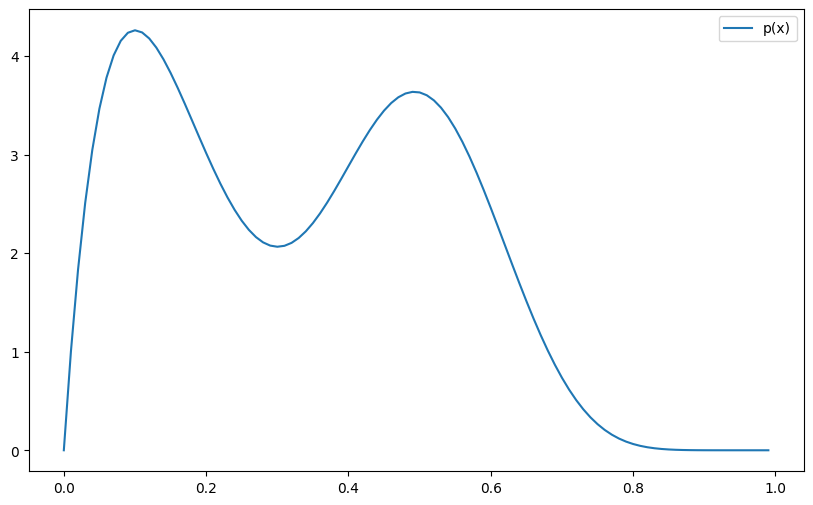

In [25]:
prior_a = 10
prior_b = 10
p_h_values_range = np.arange(1e-10, 1, 0.01)
prior_distr_1 = p_params(10, 10)
prior_distr_2 = p_params(2, 10)

plot_df = pd.DataFrame({
    '$p_h$': p_h_values_range,
    '$p(p_h)$': prior_distr_1.pdf(p_h_values_range) + prior_distr_2.pdf(p_h_values_range),
})
# fig = px.line(plot_df, x='$p_h$', y='$p(p_h)$', title=f'Prior pdf with parameters a={prior_a}, b={prior_b}')
# fig

plt.plot(plot_df['$p_h$'], plot_df['$p(p_h)$'], label='p(x)')
plt.legend()
# plt.savefig('rej_sampl.jpg')
plt.show();

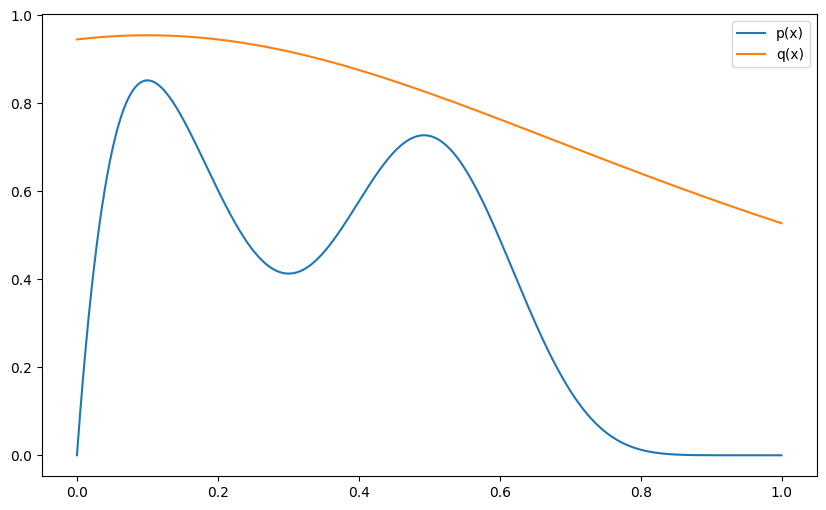

In [26]:
p_h_values_range = np.arange(0, 1, 1e-4)
prior_distr_1 = p_params(10, 10)
prior_distr_2 = p_params(2, 10)



plot_df = pd.DataFrame({
    '$p_h$': p_h_values_range,
    '$p(p_{h_1})$': prior_distr_1.pdf(p_h_values_range),
    '$p(p_{h_2})$': prior_distr_2.pdf(p_h_values_range),
    '$p(p_{h_{sum}})$': (prior_distr_1.pdf(p_h_values_range) + prior_distr_2.pdf(p_h_values_range))/5,
    '$p(p_{cauchy})$': cauchy.pdf(p_h_values_range-0.1)*3
})

plt.plot(plot_df['$p_h$'], plot_df['$p(p_{h_{sum}})$'], label='p(x)')
plt.plot(plot_df['$p_h$'], plot_df['$p(p_{cauchy})$'], label='q(x)')
plt.legend()
# plt.savefig('rej_sampl.jpg')
plt.show();


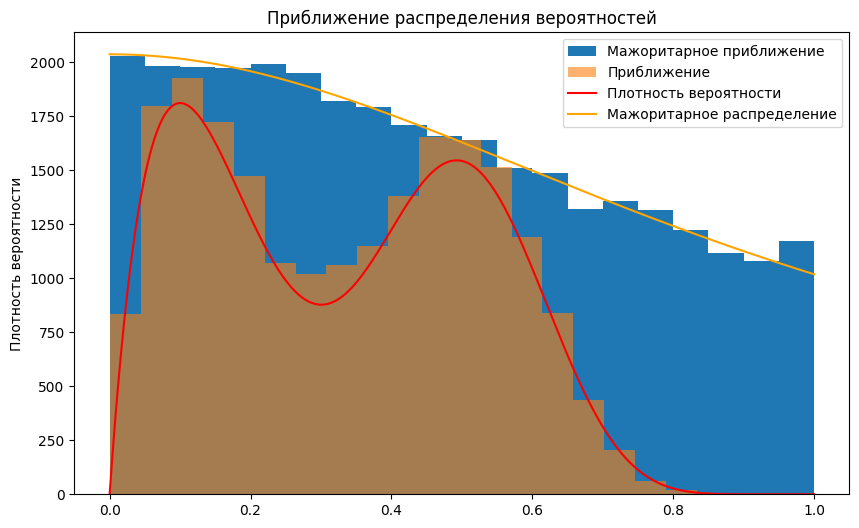

In [27]:
# Параметры бета-распределения
a = 10
b = 10

# Создание массива значений от 0 до 1
x = np.linspace(0, 1, 1000)

# Вычисление значений функции плотности бета-распределения
pdf = beta.pdf(x, 10, 10) + beta.pdf(x, 2, 10)
ca = cauchy.pdf(x, scale=1)

# Вычисление нормировочного множителя
norm_factor = np.trapz(pdf, x)
norm_factor_ca = np.trapz(ca, x)

# Нормировка функции плотности
pdf_normalized = pdf/norm_factor*8.5e2
ca_norm = ca/norm_factor_ca*16e2

# Создание гистограммы сгенерированных значений бета-распределения
# Можно нарисовать гистограмму сгенерированных значений, если это требуется
# По умолчанию, чтобы показать функцию плотности и гистограмму, укажем alpha=0.6 для прозрачности 
h = np.concatenate((beta.rvs(10, 10, size=10500), beta.rvs(2, 10, size=10500)))
ca_h = cauchy.rvs(size=128000)
ca_h = ca_h[(ca_h>0) & (ca_h<1)]

plt.hist(ca_h, bins=20, label='Мажоритарное приближение');
plt.hist(h, bins=20, alpha=0.6, label='Приближение')


# Построение графика нормированной функции плотности бета-распределения
plt.plot(x, pdf_normalized, 'r', label='Плотность вероятности')
plt.plot(x, ca_norm, color='orange', label='Мажоритарное распределение')

# Добавление легенды и подписей осей
plt.legend()
# plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.title('Приближение распределения вероятностей')
# plt.grid(True)
# plt.yticks([])

# plt.savefig('approx_distr.jpg')
# Отображение графика
plt.show()

## MCMC

### Define Markov chain with stationary state

In [28]:
import numpy as np

P = np.asarray([[0.3, 0.5, 0.75], [0.1, 0.1, 0.1], [0.6, 0.4, 0.15]])

print(f"Transition matrix P: \n{P}\n")

# Generate random initial distribution (normalize to obtain valid distribution).
pi = np.random.rand(3)
pi /= np.sum(pi)

print(f"Initial distribution pi_0: {pi}")

for i in range(50):
    pi = np.matmul(P, pi)
    if i % 5 == 0:
        print(f"Distribution after {i} steps: {pi}")

Transition matrix P: 
[[0.3  0.5  0.75]
 [0.1  0.1  0.1 ]
 [0.6  0.4  0.15]]

Initial distribution pi_0: [0.39212345 0.23495684 0.37291972]
Distribution after 0 steps: [0.51480524 0.1        0.38519476]
Distribution after 5 steps: [0.4997268 0.1       0.4002732]
Distribution after 10 steps: [0.50000504 0.1        0.39999496]
Distribution after 15 steps: [0.49999991 0.1        0.40000009]
Distribution after 20 steps: [0.5 0.1 0.4]
Distribution after 25 steps: [0.5 0.1 0.4]
Distribution after 30 steps: [0.5 0.1 0.4]
Distribution after 35 steps: [0.5 0.1 0.4]
Distribution after 40 steps: [0.5 0.1 0.4]
Distribution after 45 steps: [0.5 0.1 0.4]


### MCMC Algorithm

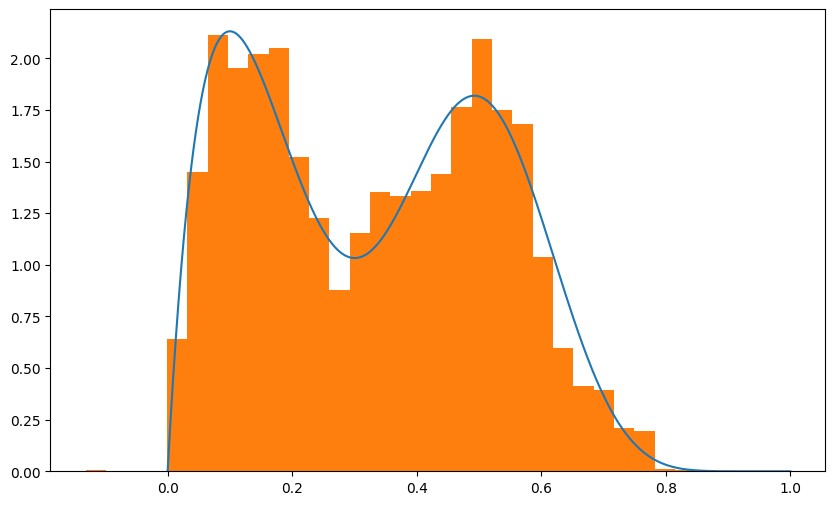

In [17]:
NUM_SAMPLES = 10000

# Target distribution
def f(x):
    return (beta.pdf(x, 10, 10) + beta.pdf(x, 2, 10))/2

# Plot target distribution
x = np.linspace(1e-10, 1, 5000)
plt.plot(x, f(x))

# Step 1
x = np.random.uniform(-2, 2)

# Proposal distribution
q = scipy.stats.norm(0, 1)


samples = []

for i in range(NUM_SAMPLES):
    # Step 2
    y = x + q.rvs()
    # Step 3
    p = min(f(y) / f(x) * q.pdf(x - y) / q.pdf(y - x), 1)
    # Step 4
    u = np.random.uniform(0, 1)
    # Step 5
    x = y if u <= p else x
    samples.append(x)

plt.hist(samples, density=True, bins=30)
plt.show()

## Using PyMc

https://allendowney.github.io/BayesianInferencePyMC/index.html

В этом примере мы используем результат хоккейного матча, чтобы оценить скорость, с которой каждая команда будет забивать другой в долгосрочной перспективе. В дальнейшем мы будем использовать эти оценки для прогнозирования.

Этот пример предназначен для использования нашей интуиции в отношении таких вещей, как игры, но методы, которые мы рассмотрим, полезны для любого приложения, где нас интересуют события, происходящие с течением времени, например, приход покупателей в магазин или диагностика заболевания у пациентов.

Многие подобные системы могут быть хорошо смоделированы пуассоновским процессом, который основан на предположении, что события случайны и с одинаковой вероятностью могут произойти в любой момент времени. Конечно, это предположение не всегда справедливо, но для моделирования его часто бывает достаточно.

В примере с забиванием голов в таких играх, как хоккей и футбол, это оказывается довольно хорошей моделью.

В хоккейной игре предположим, что каждая команда имеет некоторый долгосрочный средний показатель забитых шайб, $\mu$, в голах за игру.

Для начала предположим, что для команды A против команды B $\mu$ каким-то образом известно, что составляет 2.4 гола за игру. Если бы эти две команды сыграли 100 игр, мы бы ожидали, что команда А в среднем забивает 2.4 гола за игру.

Но в конкретной игре она может забить 2 или 3 гола, или больше, или меньше. Исходя из предположений о пуассоновском процессе, получается, что распределение забитых голов является пуассоновским с параметром $\mu=2.4$.

Чтобы посмотреть, как выглядит это распределение, я сгенерирую случайную выборку и построю гистограмму с использованием PyMC.

In [30]:
mu = 2.4
sample_poisson = pm.Poisson.dist(mu).random(size=1000)
sample_poisson.mean()

2.43

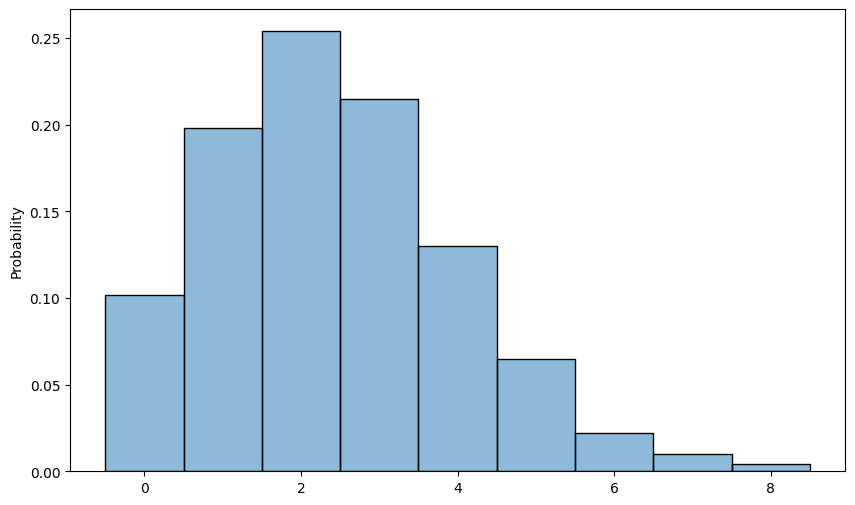

In [31]:
sns.histplot(sample_poisson, stat='probability', discrete=True,
                 alpha=0.5);


Мы предполагали, что коэффициент забитых мячей известен, но обычно его приходится оценивать. Если мы не уверены в значении $\mu$ то, мы можем использовать распределение для представления возможных значений и их относительных вероятностей.

Для представления этого распределения можно использовать гамма-распределение. Это не единственный вариант, но гамма-распределение является разумным выбором, поскольку:

- Значения в гамма-распределении непрерывны и неотрицательны, поэтому оно подходит для представления количества забитых мячей.
- Форма гамма-распределения соответствует тому, что мы знаем о забивании голов в таких играх, как хоккей.

Формой гамма-распределения управляют два параметра - альфа и бета.

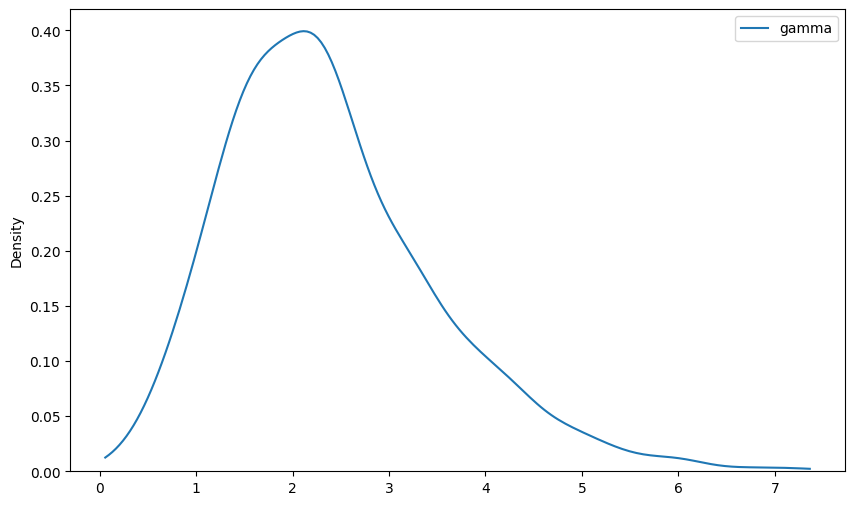

In [32]:
alpha = 4.6
beta = 1.9

sample_gamma = pm.Gamma.dist(alpha, beta).random(size=1000)


sns.kdeplot(sample_gamma, cut=0, label='gamma');
plt.legend();

Это распределение представляет собой возможные показатели забитых мячей одной команды против другой. Когда худшая команда играет с лучшей, коэффициент забитых мячей может быть близок к 0. Когда лучшая команда играет с худшей, коэффициент забитых мячей может составлять 8 мячей за игру или даже больше. Но для большинства команд мы ожидаем, что коэффициент забитых голов будет около 2.

C помощью PyMC можно генерировать случайные величины из распределения. Но чаще всего PyMC используется для создания модели, отображающей случайные величины и связи между ними.

In [33]:
with pm.Model() as model1:
    mu = pm.Gamma('mu', alpha, beta)
    trace1 = pm.sample_prior_predictive(1000)

Первая строка создает пустую модель. Оператор with создает контекст, чтобы величины, которые мы создаем внутри, были добавлены в модель.

Эта модель содержит гамма-распределение с именем mu и параметрами alpha и beta.

Затем используется sample_prior_predictive для генерации выборки из этого распределения. 

В результате получается "след", который похож на словарь, отображающий имена из выборки. Если мы выберем имя mu, то получим выборку из гамма-распределения.

В данном примере гамма-распределение является предварительным распределением mu, т.е. оно отражает наши знания о количестве забитых мячей в целом, а не о количестве забитых мячей одной командой против другой.

Другими словами, если мы не знаем, какие две команды играют, то это распределение представляет собой то, что мы будем считать mu. 

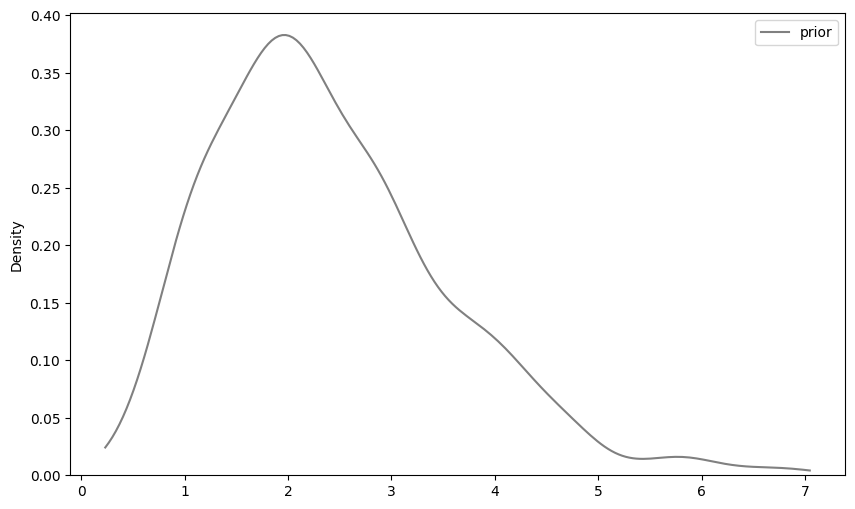

In [34]:
sample_prior = trace1['mu']
sns.kdeplot(sample_prior, cut=0, color='gray', label='prior');
plt.legend();


In [35]:
with pm.Model() as model2:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace2 = pm.sample_prior_predictive(1000)

Как и в предыдущей модели, mu - это коэффициент забитых мячей, взятый из гамма-распределения. А теперь goals - количество голов, забитых в конкретной игре, взятое из распределения Пуассона.

И, что очень важно, обратите внимание на связь между ними: параметр пуассоновского распределения - это значение mu взятое из гамма-распределения.

PyMC предоставляет функцию, которая представляет модель в виде графика, показывающего связи между величинами.

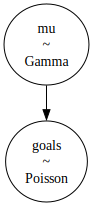

In [36]:
pm.model_to_graphviz(model2)

Напомним, что mu - это коэффициент по голам за игру, а goals - целое число голов.

Распределение mu, полученное в этой модели, является априорным распределением (prior).

Распределение голов является предварительным прогнозирующим распределением (prior predictive), поскольку оно представляет собой количество голов, которое мы могли бы предсказать, основываясь на предварительном распределении mu.

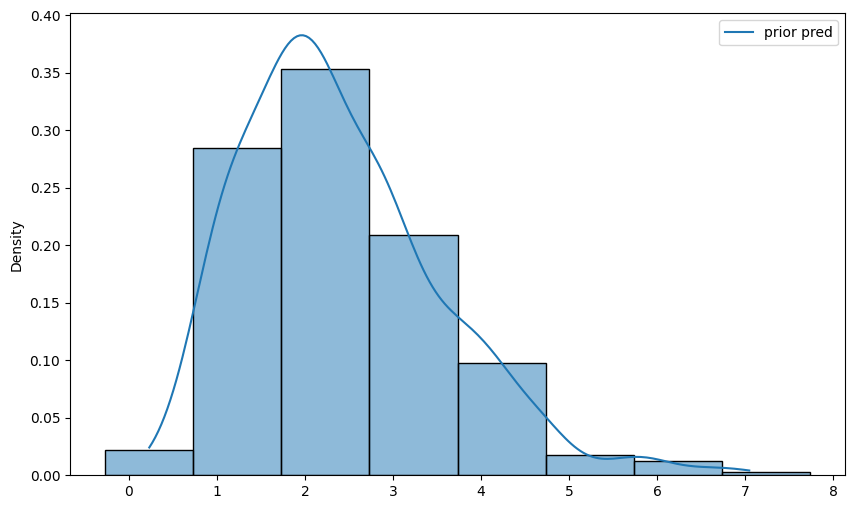

In [37]:
sample_prior_pred = trace2['goals']
sns.kdeplot(sample_prior, cut=0, label='prior pred');
sns.histplot(sample_prior, stat='probability', discrete=True,
                 alpha=0.5);
plt.legend();

Предварительное прогнозируемое распределение показывает распределение голов, которое мы должны ожидать в игре, основываясь только на априорном распределении, а не на данных.

До сих пор мы моделировали систему в прямом направлении, то есть, задавая распределения и их параметры, генерировали возможные исходы.

Теперь мы начнем прогонять модель назад; учитывая реальный результат, мы будем оценивать, какими могли быть параметры. Этот процесс называется выводом (inference).

И вот здесь мы открываем для себя возможности PyMC. Поскольку модель уже задана, мы можем использовать ее для вывода, сделав всего два изменения:

Вместо генерации целей мы пометим цели как наблюдаемые и предоставим наблюдаемые данные.
И вместо вызова sample_prior_predictive мы будем вызывать sample.
Для данных предположим, что команда A играет с командой B и забивает 4 гола. 

Bug report #14901 (https://github.com/scipy/scipy/issues/14901)

In [38]:
with pm.Model() as model3:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace3 = pm.sample()

/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


На выходе получается информация о том, как происходил процесс выборки. Результатом является объект трассировки, аналогичный объекту из предыдущей модели. Отличия заключаются в следующем:

Поскольку мы предоставили наблюдаемые данные о целях, трассировка не содержит случайной выборки целей.
Значения mu в "следе" - это выборка из апостериорного распределения, которое представляет собой то, что мы считаем о mu на основе данных.


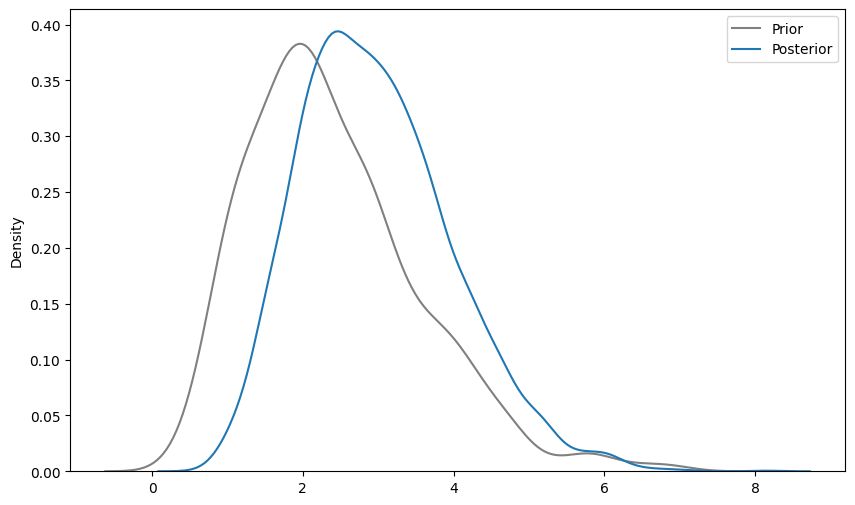

In [39]:
sample_posterior = trace3['mu']
sns.kdeplot(sample_prior, label='Prior', color='gray');
sns.kdeplot(sample_posterior, label='Posterior');
plt.legend();

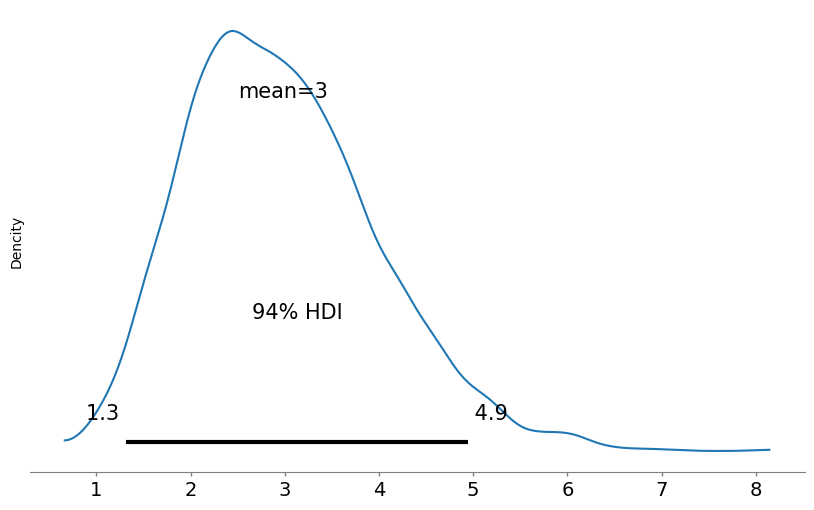

In [40]:
az.plot_posterior(sample_posterior)
plt.ylabel('Dencity');
plt.title('');

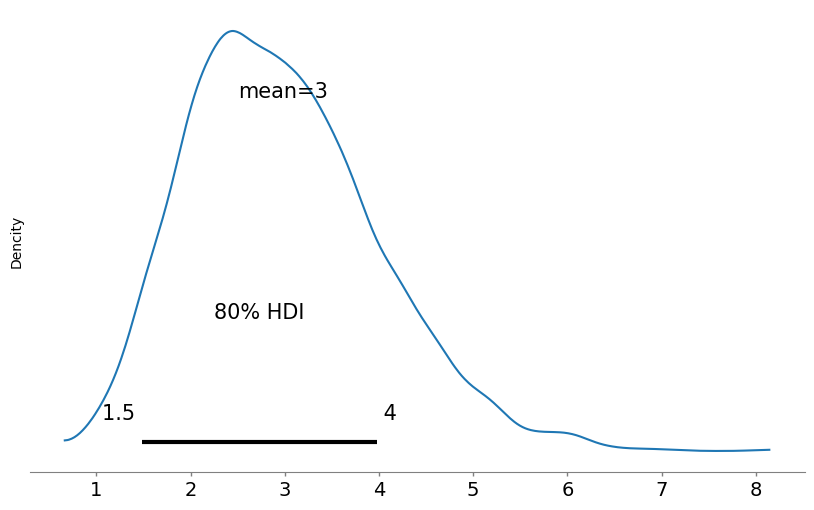

In [41]:
az.plot_posterior(sample_posterior, hdi_prob = 0.80)
plt.ylabel('Dencity');
plt.title('');

In [42]:
az.hdi(sample_posterior, hdi_prob = 0.80)

array([1.48008934, 3.9802096 ])

In [65]:
az.hdi(sample_posterior, hdi_prob = 0.94)

array([1.1527251 , 4.80655147])

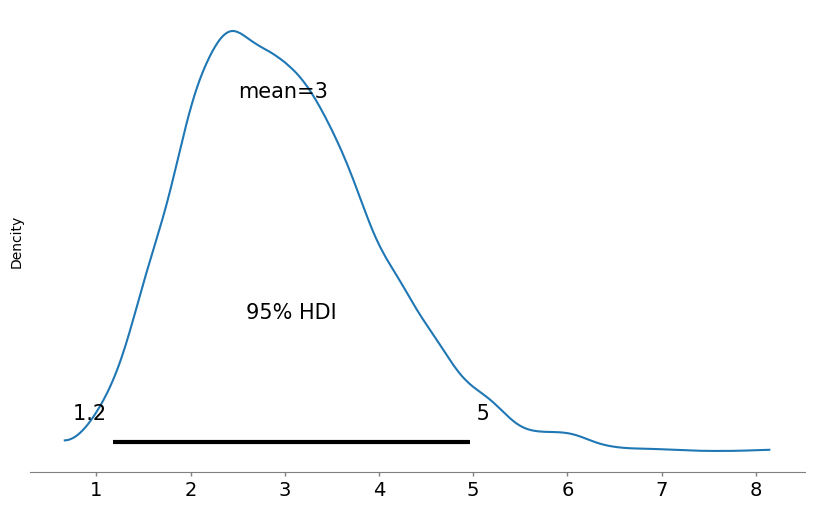

In [43]:
az.plot_posterior(sample_posterior, hdi_prob = 0.95)
plt.ylabel('Dencity');
plt.title('');

In [67]:
az.hdi(sample_posterior, hdi_prob = 0.95)

array([1.04971135, 4.83438661])

In [68]:
az.hdi(sample_posterior, hdi_prob = 0.95).mean()

2.942048981466171

#### Среднее значение априорного распределения составляет около 2,4. Команда забила 4 гола, что больше, чем ожидалось, поэтому апостериорное распределение смещено вправо.

Среднее апостериорное распределение равно примерно 3, поэтому оно находится между предварительным ожиданием и наблюдаемым результатом.

HDI 95% - это доверительный интервал, который охватывает 95% апостериорного распределения. На основании результатов одной игры можно с вероятностью 95% предположить, что фактическое количество забитых мячей попадает в этот интервал (по крайней мере, при допущениях модели).

Мы можем расширить модель, чтобы оценить различные значения mu для двух команд.

Например, предположим, что команда A забила 5 голов, а команда B - 1. Следующая модель оценивает их коэффициенты забитых мячей по отношению друг к другу.

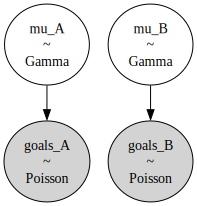

In [44]:
alpha = 4.6
beta = 1.9

with pm.Model() as model4:
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5])
    goals_B = pm.Poisson('goals_B', mu_B, observed=[1])
    
pm.model_to_graphviz(model4)

In [45]:
with model4:
    trace4 = pm.sample(500)

/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A]


/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 11 seconds.


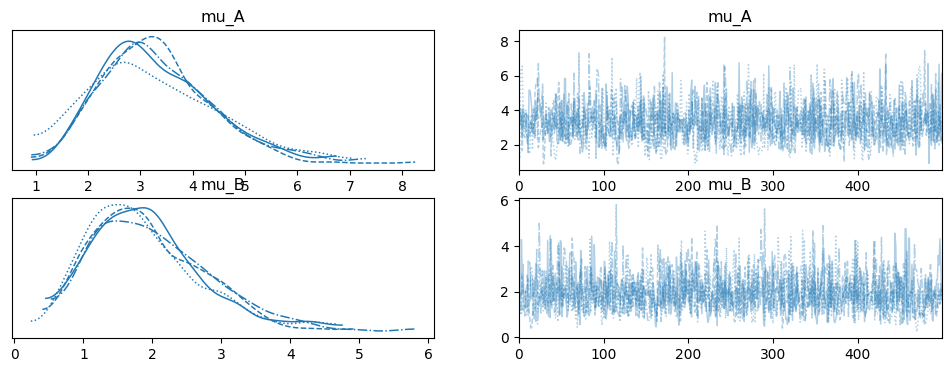

In [46]:
with model4:
    az.plot_trace(trace4)

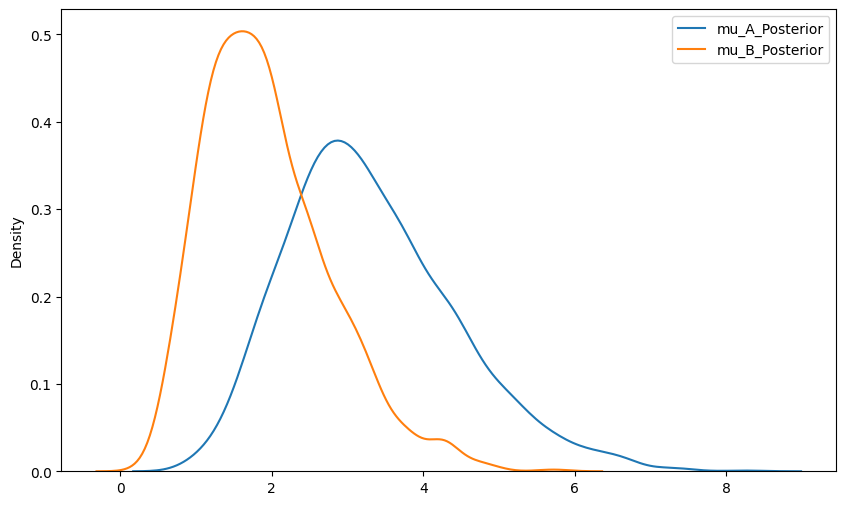

In [47]:
mu_A = trace4['mu_A']
mu_B = trace4['mu_B']

sns.kdeplot(mu_A, label='mu_A_Posterior');
sns.kdeplot(mu_B, label='mu_B_Posterior');
plt.legend();

Насколько можно быть уверенным в том, что команда A - лучшая команда, на основании одной игры? Одним из способов ответа на этот вопрос является вычисление вероятности превосходства (probability of superiority), которая представляет собой вероятность того, что случайная величина из апостериорного распределения команды A превысит случайную величину из апостериорного распределения команды B.

In [48]:
(mu_A > mu_B).mean()

0.844

С результатом 5:1 у нас есть некоторая уверенность в том, что команда А лучше, но это не точно.

Теперь обратимся к задаче прогнозирования, т.е. с учетом того, что мы знаем о mu, какое распределение голов следует ожидать, если те же команды сыграют снова. Исходя из этого, мы можем вычислить вероятность того, что каждая из команд выиграет матч-реванш.

Итак, наша модель:

/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 10 seconds.


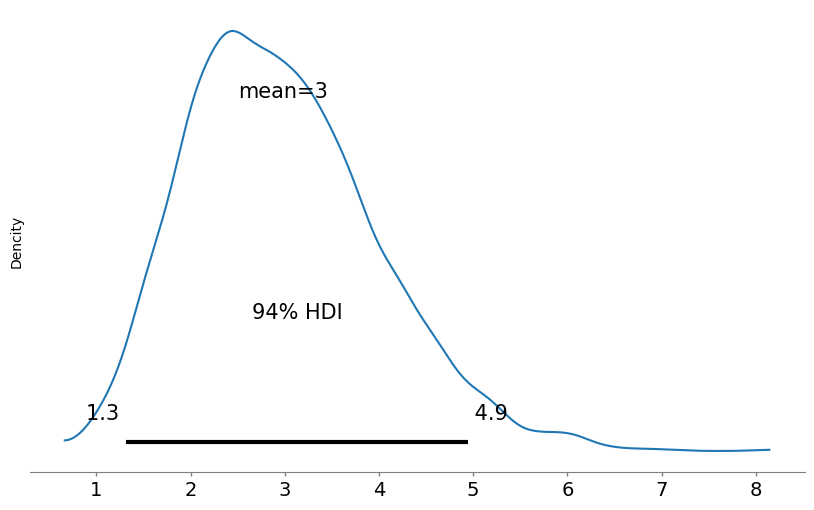

In [50]:
alpha = 4.6
beta = 1.9

with pm.Model() as model3:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace1 = pm.sample(500)

sample_posterior = trace3['mu']
az.plot_posterior(sample_posterior)
plt.ylabel('Dencity');
plt.title('');

Это постериорное распределение.
Это говорит нам о том, что мы должны думать о mu после того, как увидим данные, но не говорит нам о том, сколько голов мы должны ожидать в будущем. Для этого нам необходимо апостериорное прогнозное распределение, которое мы можем получить, выполнив sample_posterior_predictive:

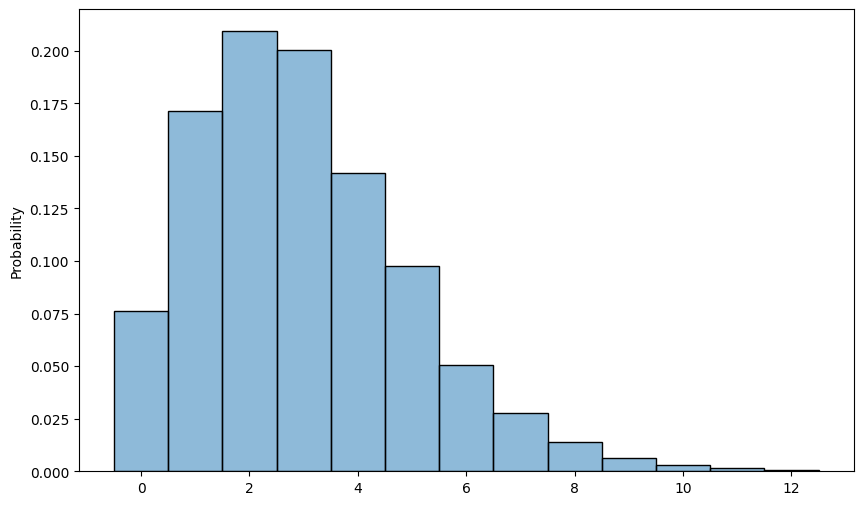

In [51]:
with model3:
    post_pred = pm.sample_posterior_predictive(trace3)
    
sample_post_pred = post_pred['goals']

sns.histplot(sample_post_pred, stat='probability', discrete=True,
                 alpha=0.5);

предположим, что две команды сыграли друг с другом дважды, команда А выиграла первую игру со счетом 5:1, а вторую - 3:1. Следующая модель рассчитывает апостериорное распределение для каждой команды на основе этих исходов.

In [52]:
with pm.Model() as model2:
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5,3])
    goals_B = pm.Poisson('goals_B', mu_B, observed=[1,1])
    trace2 = pm.sample(500)

/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A]


/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 10 seconds.


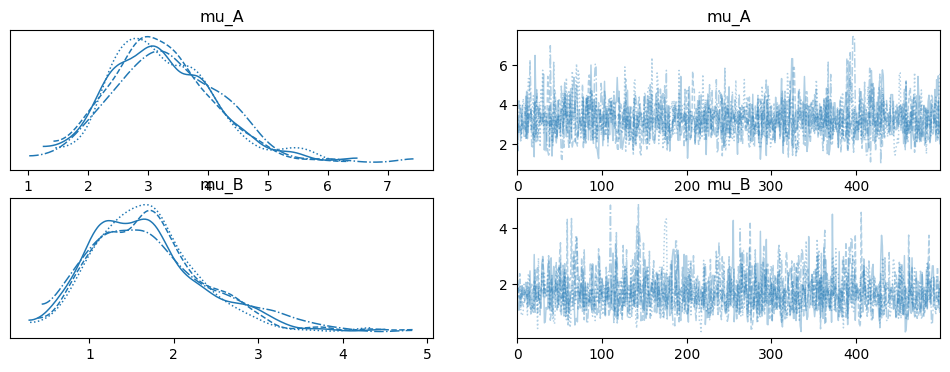

In [53]:
import arviz as az

with model2:
    az.plot_trace(trace2);

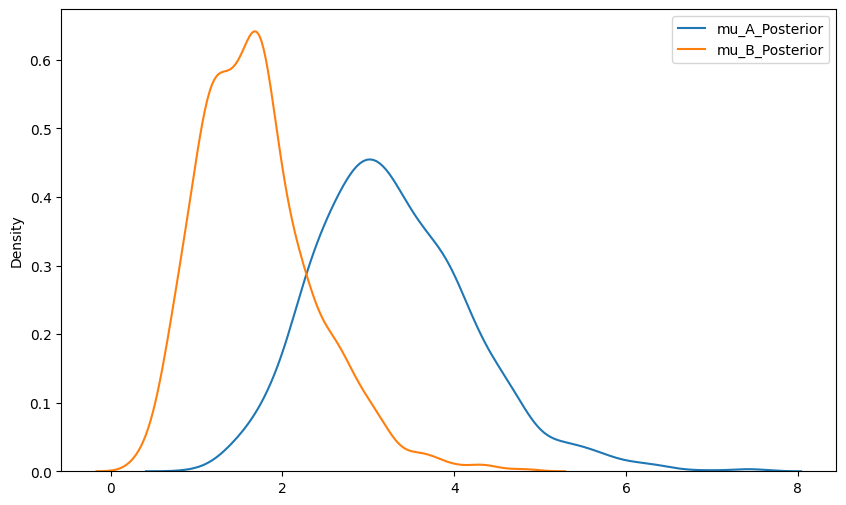

In [54]:
mu_A = trace2['mu_A']
mu_B = trace2['mu_B']
sns.kdeplot(mu_A, label='mu_A_Posterior');
sns.kdeplot(mu_B, label='mu_B_Posterior');
plt.legend();

In [96]:
(mu_A > mu_B).mean()

0.9215

Для вычисления вероятности того, что A выиграет следующую партию, мы можем использовать sample_posterior_predictive для генерации прогнозов.

In [55]:
with model2:
    post_pred = pm.sample_posterior_predictive(trace2)

In [56]:
goals_A = post_pred['goals_A'].flatten()
goals_B = post_pred['goals_B'].flatten()

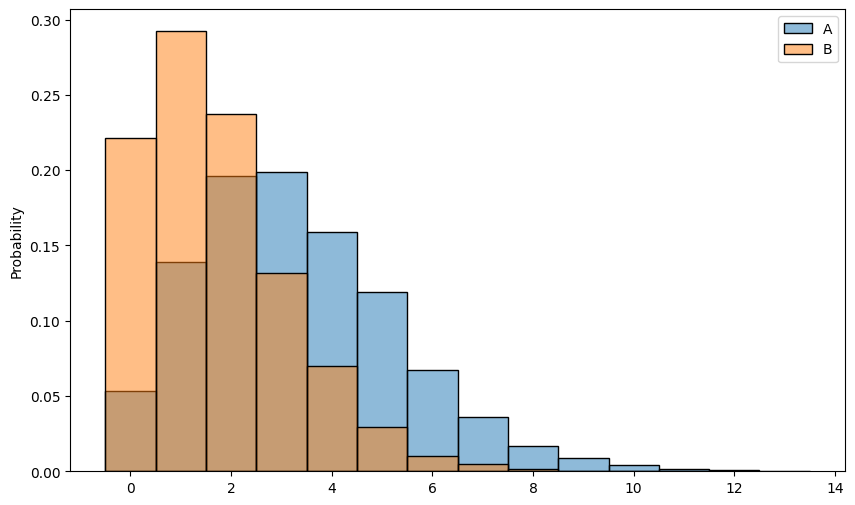

In [57]:
sns.histplot(goals_A, stat='probability', discrete=True,
                 alpha=0.5, label='A');
sns.histplot(goals_B, stat='probability', discrete=True,
                 alpha=0.5, color='C1', label='B');
plt.legend();

Команда B с большей вероятностью, чем команда A, забьет 0, 1 или 2 гола. Вероятность того, что команда А забьет 3 или более голов, выше.

Вот вероятность того, что команда A выиграет следующую игру.

In [58]:
(goals_A > goals_B).mean()

0.658

## coin analisys with PyMC3

Предположим, что мы точно знаем, что монета честная, 
т.е. вероятность выпадения орлов составляет ровно 50\%. 
Если мы покрутим монету на ребрe 250 раз, то ожидаем, 
что число голов будет соответствовать биномиальному распределению с параметрами 
n=250 и p=0,5.

И мы можем использовать PyMC для генерации выборки значений из этого распределения.

In [59]:
n = 250
p = 0.5

sample_binomial = pm.Binomial.dist(n, p).random(size=1000)

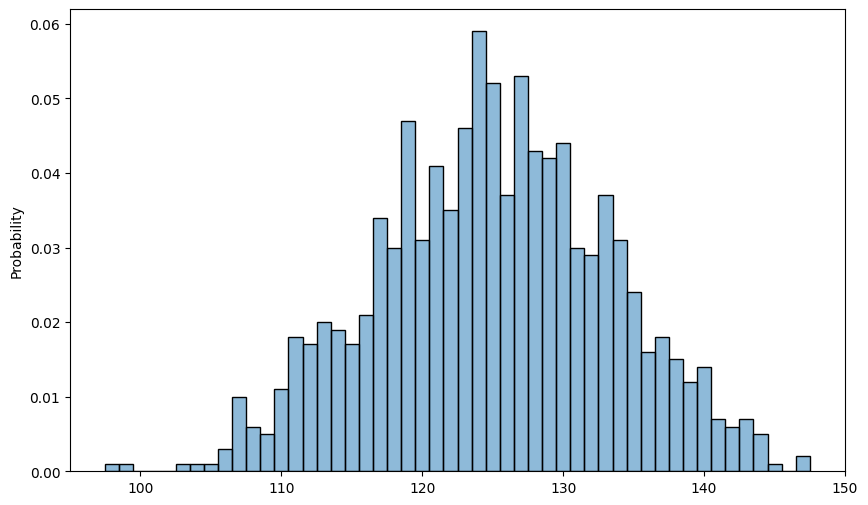

In [60]:
sns.histplot(sample_binomial, stat='probability', discrete=True,
                 alpha=0.5, label='Binomial');

Ранее мы предполагали, что реальная вероятность появления орлов известна, но в общем случае это не так. А для задачи о монете вероятность орлов - это то, что мы хотели бы оценить.

Поэтому, подобно тому как использовали гамма-распределение для представления возможных значений коэффициента забитых голов, $\mu$, теперь мы будем использовать бета-распределение для представления возможных значений вероятности голов, которую будем называть x.

Бета-распределение не является единственно возможным, но оно непрерывно и определено для значений от 0 до 1 (включая оба значения), поэтому оно подходит для значений, являющихся вероятностями.

In [61]:
a = 2
b = 2

sample_beta = pm.Beta.dist(alpha=a, beta=b).random(size=1000)

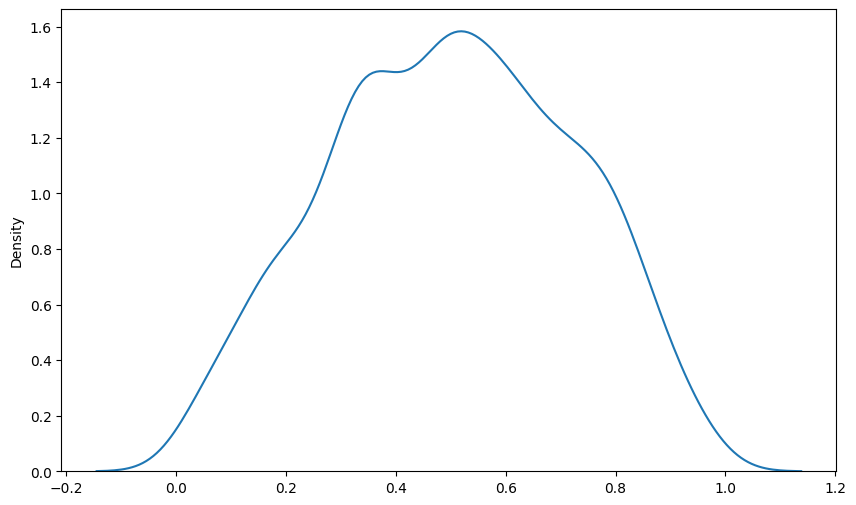

In [62]:
sns.kdeplot(sample_beta, label='Beta');

Для моделирования процесса бросания монет я возьму значения x из бета-распределения, а затем значения k из биномиального распределения.

Помните, что x - это вероятность выпадения орлов, которая является непрерывной величиной в диапазоне от 0 до 1, а k - это количество орлов, которое является целым числом в диапазоне от 0 до n.

Вот как выглядит модель в PyMC.

In [64]:
a = 2
b = 2
n = 250

with pm.Model() as model1:
    x = pm.Beta('x', alpha=a, beta=b)
    k = pm.Binomial('k', n=n, p=x)
    trace1 = pm.sample_prior_predictive(1000)

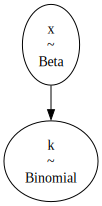

In [65]:
pm.model_to_graphviz(model1)

In [66]:
# априорная оценка
sample_prior = trace1['x']

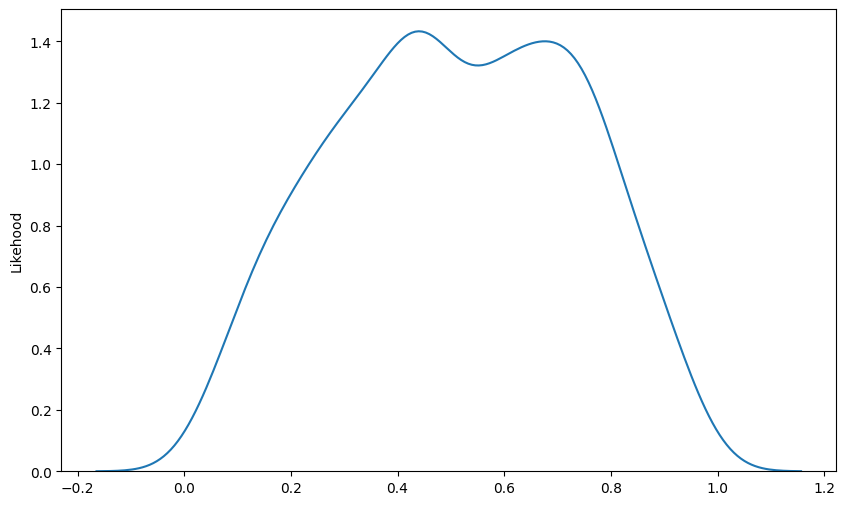

In [67]:
sns.kdeplot(sample_prior);
plt.ylabel('Likehood');

Это распределение отражает мнение о монетах; в частности, оно предполагает, что большинство монет близки к честным, со значениями x между 0,4 и 0,6, но некоторые монеты сильно смещены, со значениями x около 0 и 1.

В действительности, я подозреваю, что монеты не настолько изменчивы; я могу представить, что x может быть как низким 0,4, так и высоким 0,6, но я был бы удивлен, если бы оно сильно выходило за пределы этого диапазона.

Таким образом, эта предварительная оценка может не отражать всего, что мы знаем о монетах, но в данном примере она не сильно влияет на результат.

### Предварительное прогнозируемое распределение¶
Из той же трассы мы можем извлечь k, которое представляет собой предварительное прогнозируемое распределение. Оно представляет собой ожидаемое число орлов при n=250, основанное на предварительном распределении x.

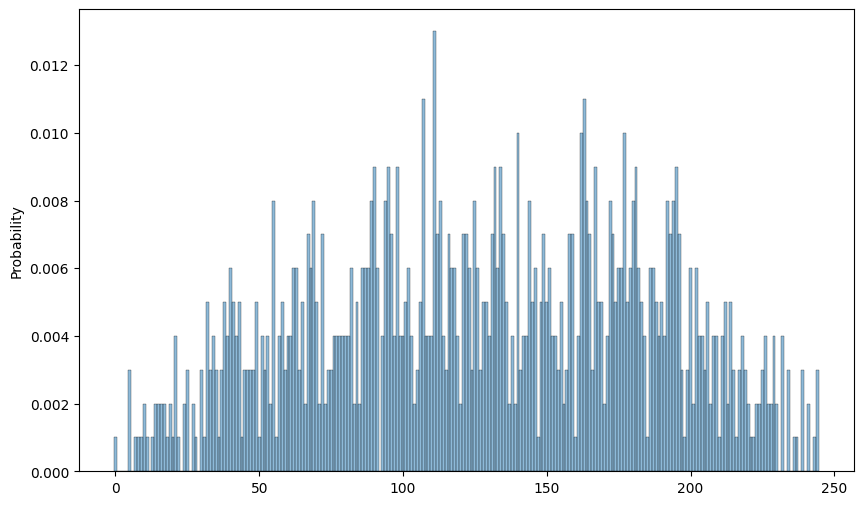

In [68]:
sample_prior_pred = trace1['k']
sns.histplot(sample_prior_pred, stat='probability', discrete=True,
                 alpha=0.5, label='Prior predictive distribution');

### Inference

In [69]:
k_obs = 140

with pm.Model() as model2:
    x = pm.Beta('x', alpha=2, beta=2)
    k = pm.Binomial('k', n=n, p=x, observed=k_obs)
    trace2 = pm.sample(500)

/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 10 seconds.


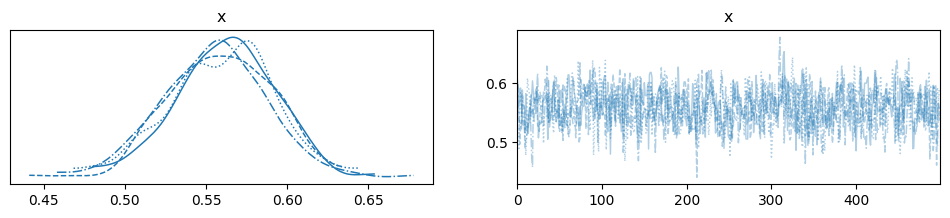

In [70]:
with model2:
    az.plot_trace(trace2)

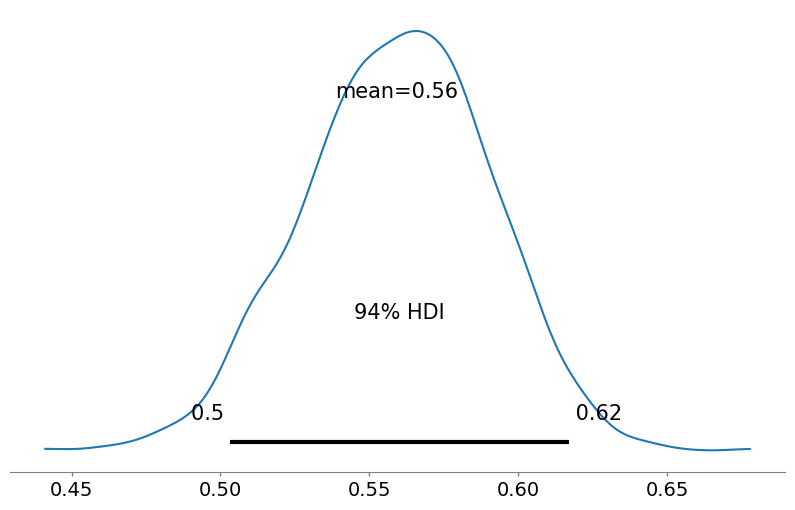

In [71]:
with model2:
    az.plot_posterior(trace2)
    
plt.title('');

# Homework

Мы можем использовать апостериорное прогнозируемое распределение для предсказания того, что произойдет, если мы снова подбросим ту же монету.

Используйте sample_posterior_predictive для генерации выборки k, а затем используйте plot_hist для построения графика апостериорного предсказательного распределения.